In [1]:
import pandas as pd
import sweetviz as sv
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode


%matplotlib inline

In [2]:
# Парсим пользователей
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
customers = pd.read_csv(download_url, sep=',')

In [3]:
# Парсим заказы
public_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
orders = pd.read_csv(download_url, sep=',', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [4]:
# Парсим товары
public_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
order_items = pd.read_csv(download_url, sep=',', parse_dates=['shipping_limit_date'])

In [5]:
customers = pd.read_csv('/Users/vboitcev/Desktop/first_project/olist_customers_dataset.csv', sep=',')
orders = pd.read_csv('/Users/vboitcev/Desktop/first_project/olist_orders_dataset.csv', sep=',', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
order_items = pd.read_csv('/Users/vboitcev/Desktop/first_project/olist_order_items_dataset.csv', sep=',', parse_dates=['shipping_limit_date'])

# Предварительный анализ данных 

Буду использовать для предварительного анализа библиотеку "sweetviz"

In [6]:
# Отчет для датафрейма с пользователями
report_customers = sv.analyze([customers, " customers"])

                                             |          | [  0%]   00:00 -> (? left)

In [331]:
# Вывод отчета через браузер
report_customers.show_html('report_customers.html')

Report report_customers.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



Пропущенные значения в массиве по пользователям отсутствуют

In [6]:
# Отчет для датафрейма с заказами
report_orders = sv.analyze([orders, " Orders"])

                                             |      | [  0%]   00:00 -> (? left)

In [7]:
# Вывод отчета через браузер
report_orders.show_html('report_orders.html')

NameError: name 'report_orders' is not defined


Пропущенные значения в массиве по заказам:

+ order_approved_at - 160 (<1%) 
+ order_delivered_carrier_date - 1,783 (2%) 
+ order_delivered_customer_date - 2,965 (3%)

Распределение статусов заказов

- delivered 96,478 (97%)
- shipped 1,107 (1%)
- canceled 625 (<1%)
- unavailable 609 (<1%)
- invoiced 314 (<1%)
- processing 301 (<1%)
- created 5 (<1%)
- approved 2 (<1%)

Доставлено только 97% заказов.

In [8]:
# Даты мы привели к формату datetime еще на уровне считывания csv файлов, поэтому менять ничего не нужно
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [9]:
# Отчет для датафрейма с товарами
report_order_items = sv.analyze([order_items, " Order_items"])

                                             |          | [  0%]   00:00 -> (? left)

In [10]:
# Вывод отчета через браузер
report_order_items.show_html('Order_items.html')

Report Order_items.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Пропущенные значения в массиве по товарам отсутствуют

# Задание 1

**Сколько у нас пользователей, которые совершили покупку только один раз?**

За покупку будем считать все заказы, у которых есть подтвержденная оплата (order_approved_at) и статус заказа не canceled (отменен) или unavailable (недоступен), так как деньги за заказы с таким статусом компания не получит.

Для задачи нам потребуется объединить заказы и пользователей, чтобы получить доступ к покупкам уникальных пользователей, а не позаказным id.

In [14]:
# Соединиям заказы и уникальных пользователей в новый датафрейм
customers_and_orders = orders.merge(customers, on='customer_id')

In [11]:
customers_and_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [16]:
customers_and_orders.query('order_approved_at.isna() != True')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [341]:
# Берем пользователей, которые совершали покупки
customers_purchases = customers_and_orders \
                .query("order_approved_at.isna() != True and order_status not in ('canceled', 'unavailable')") \
                .groupby(['customer_unique_id']) \
                .agg({'order_id': 'nunique'}) \
                .rename(columns={'order_id': 'buy_count'}) \
                .reset_index()

In [342]:
# Кол-во пользователей, которые совершили только 1 покупку
customers_make_one_purchase = customers_purchases.loc[customers_purchases.buy_count == 1]

In [343]:
customers_make_one_purchase.customer_unique_id.count()

92087

In [344]:
# Определяем процент пользователей, которые совершили только одну покупку
round(customers_make_one_purchase.customer_unique_id.count() / customers_purchases.customer_unique_id.count() * 100, 0)

97.0

92 087 пользователей совершили только 1 покупку, это 97% от всех пользователей, которые делали покупки

# Задание 2

**Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

Недоставленными заказами будем считать заказы, у которых в колонке order_delivered_customer_date пропущены значения. 

Причины отберем из статусов заказа:

- shipped (в процессе доставки)- 1107
- canceled (отменен) - 619
- unavailable (недоступен) - 609
- invoiced (в процессе оплаты) - 314
- processing (в процессе сборки) - 301
- delivered (доставлен, ошибка системы) - 8
- created (создан) - 5
- approved (подтвержден) - 2

Если система работает неисправно, то любой из статусов может стать причиной (из-за ошибки). Но за ошибку мы возьмем только статус delivered, так как данные по нему не сходятся с колонкой order_delivered_customer_date. Также мы возьмем за причину статус canceled и unavailable, так как заказы по ним уже не будут доставлены. Можно еще взять shipped и проверить задержку доставки (товары могли зависнуть в доставке надолго по разным причинам), но мы ограничимся 3 статусами.

Таким образом у нас 3 причины у недоставленных заказов: canceled (отменен), unavailable (недоступен), delivered (ошибка системы).

In [345]:
# Создаем датафрейм с заказами, которые не были доставлены
undelivered_orders = orders.loc[orders.order_delivered_customer_date.isna() == True]

In [346]:
# Добавляем колонку с годом и месяцем
undelivered_orders['delivery_by_month'] = orders['order_estimated_delivery_date'].dt.to_period('M')

/var/folders/6l/mrkqpxp572v81fff34ysdz1r0000gn/T/ipykernel_1801/1390250023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undelivered_orders['delivery_by_month'] = orders['order_estimated_delivery_date'].dt.to_period('M')


In [347]:
# Создаем датафрейм с недоставленным заказами (на основе отобранных статусов) по месяцам
undelivered_orders_by_month = undelivered_orders.query("order_status in ('canceled', 'unavailable', 'delivered')") \
                .groupby(['delivery_by_month', 'order_status']) \
                .agg({'order_id': 'nunique'}) \
                .rename(columns={'order_id': 'order_count'}) \
                .reset_index()

In [349]:
undelivered_orders_by_month.head()

,delivery_by_month,order_status,order_count
0,2016-09,canceled,1
1,2016-10,canceled,3
2,2016-11,canceled,10
3,2016-11,unavailable,5
4,2016-12,canceled,7


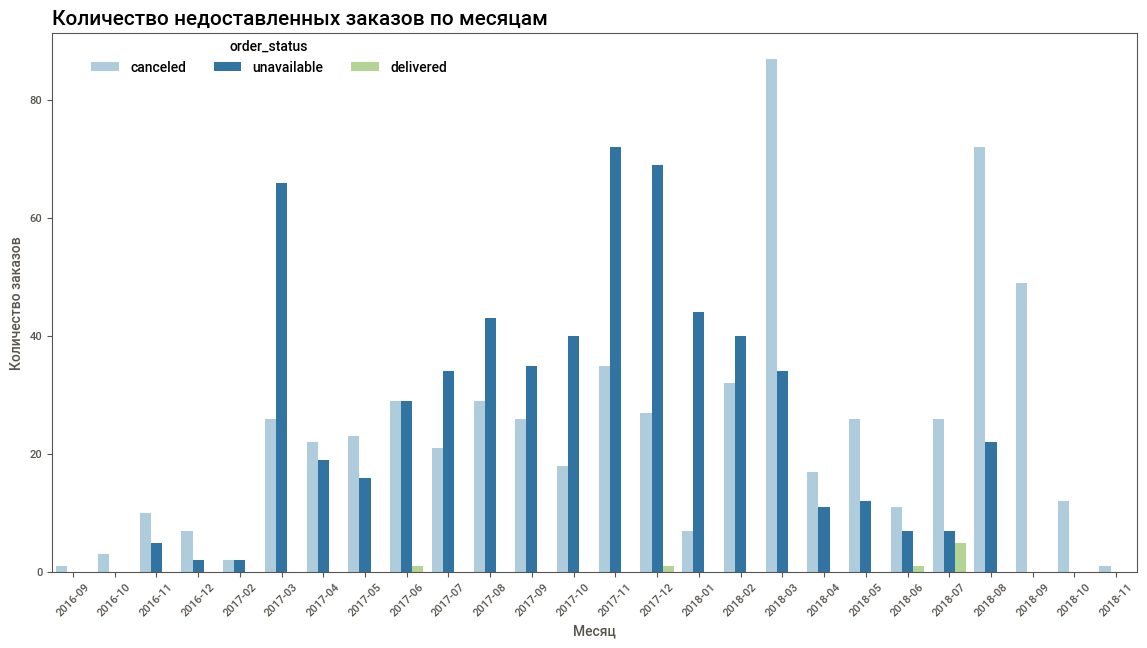

In [350]:
# Визуализируем данные с помощью seasborn barplot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=undelivered_orders_by_month, x='delivery_by_month', y='order_count', hue='order_status', palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.2, 0.9), ncol=3, frameon=False,
)
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество недоставленных заказов по месяцам', fontsize= 15 , loc='left')
plt.show()

In [351]:
# Группируем среднее в месяц по причинам
undelivered_orders_by_month.groupby(['order_status']) \
                .agg({'order_count': 'mean'}) \
                .rename(columns={'order_count': 'order_count_mean'}) \
                .round(1) \
                .reset_index()

,order_status,order_count_mean
0,canceled,23.8
1,delivered,2.0
2,unavailable,29.0


В среднем в месяц не доставляются:
    
- 23 заказа - из-за отмены
- 2 заказа - из-за ошибки системы
- 29 заказов - из-за статуса "недоступен"

# Задание 3

**По каждому товару определить, в какой день недели товар чаще всего покупается.**

Для задачи нам потребуется объединить объединить заказы и товары. Сделаем merge через right, чтобы подцепить продукты, которые вообще не заказывали (если такие есть).

In [352]:
# Мерджим заказы и продукты
orders_and_order_items = orders.merge(order_items, how='right',on='order_id')

In [353]:
# Создадим датафрейм для продуктов, где нет факта оплаты. Занесем данные в переменную. 
items_without_pay = orders_and_order_items.loc[orders_and_order_items.order_approved_at.isna()].reset_index()

In [354]:
items_without_pay

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,8204,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
1,19005,2babbb4b15e6d2dfe95e2de765c97bce,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 16:15:03,79.99,26.82
2,20473,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23
3,26393,3c0b8706b065f9919d0505d3b3343881,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23,1,db8ed3d08891d16a2438a67ab3acb740,004c9cd9d87a3c30c522c48c4fc07416,2017-02-22 14:53:27,133.99,23.20
4,36128,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16
5,40822,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82
6,49309,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52
7,49336,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
8,59699,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52
9,59700,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,2,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52


У 15 строк нет факта оплаты, при этом все остальные данные по заказам есть (все они были доставлены). Спишем это на ошибку системы и не будем использовать в решении задачи данные по продуктам из этих заказов. 

In [355]:
# Проверяем, есть ли товары, которые не заказывали
orders_and_order_items.order_id.isna().sum()

0

In [356]:
# Оставляем товары, которые покупались
items_with_pay = orders_and_order_items.query('order_approved_at.isna() == False')

In [357]:
# Создаем колонку с днями недели
items_with_pay['day_of_week'] = items_with_pay.order_approved_at.dt.day_of_week

/var/folders/6l/mrkqpxp572v81fff34ysdz1r0000gn/T/ipykernel_1801/3010301483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_with_pay['day_of_week'] = items_with_pay.order_approved_at.dt.day_of_week


In [358]:
# Создаем словарик с названиями дней недели
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [359]:
# применяем наш словарик к колонке через метод map
items_with_pay['day_of_week'] = items_with_pay['day_of_week'].map(days)

/var/folders/6l/mrkqpxp572v81fff34ysdz1r0000gn/T/ipykernel_1801/1464179525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_with_pay['day_of_week'] = items_with_pay['day_of_week'].map(days)


In [360]:
# Группируем массив по продуктам и дня недели
items_with_pay_by_weekday = items_with_pay.groupby(['product_id', 'day_of_week']) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'count'}) \
    .sort_values('count', ascending=False) \
    .reset_index()

In [361]:
items_with_pay_by_weekday.head()

,product_id,day_of_week,count
0,53b36df67ebb7c41585e8d54d6772e08,Tuesday,97
1,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,97
2,99a4788cb24856965c36a24e339b6058,Tuesday,78
3,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,77
4,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,74


In [362]:
# Находим дни недели, в которые продукты покупали больше всего
items_with_pay_by_weekday.groupby(['product_id', 'day_of_week']).max() \
                .sort_values('count', ascending=False) \
                .reset_index()

,product_id,day_of_week,count
0,53b36df67ebb7c41585e8d54d6772e08,Tuesday,97
1,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,97
2,99a4788cb24856965c36a24e339b6058,Tuesday,78
3,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,77
4,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,74
...,...,...,...
61138,60a8d8f0434c4531bf310eebf9f19cfe,Saturday,1
61139,60a8d8f0434c4531bf310eebf9f19cfe,Tuesday,1
61140,60a8d8f0434c4531bf310eebf9f19cfe,Wednesday,1
61141,60aa11b81de4e2fed1ba0961cbfc97e3,Tuesday,1


Вариант ниже также позволит найти дни недели с максимальным значением, при этом если максимальные значения
будут повторяться, то он покажет их все. Первый вариант показывает только одно максимальное значение. 

In [363]:
# Закомментировал, потому что сильно нагружает систему при выполнении)))
# largest_items_with_pay_by_weekday = items_with_pay_by_weekday.groupby(['product_id', 'day_of_week'])['order_id'].nlargest(1, keep='all')

Дополнительно решил посмотреть топ дней по продажам продуктов. 

In [364]:
# Предварительно сделаем порядок для графика
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

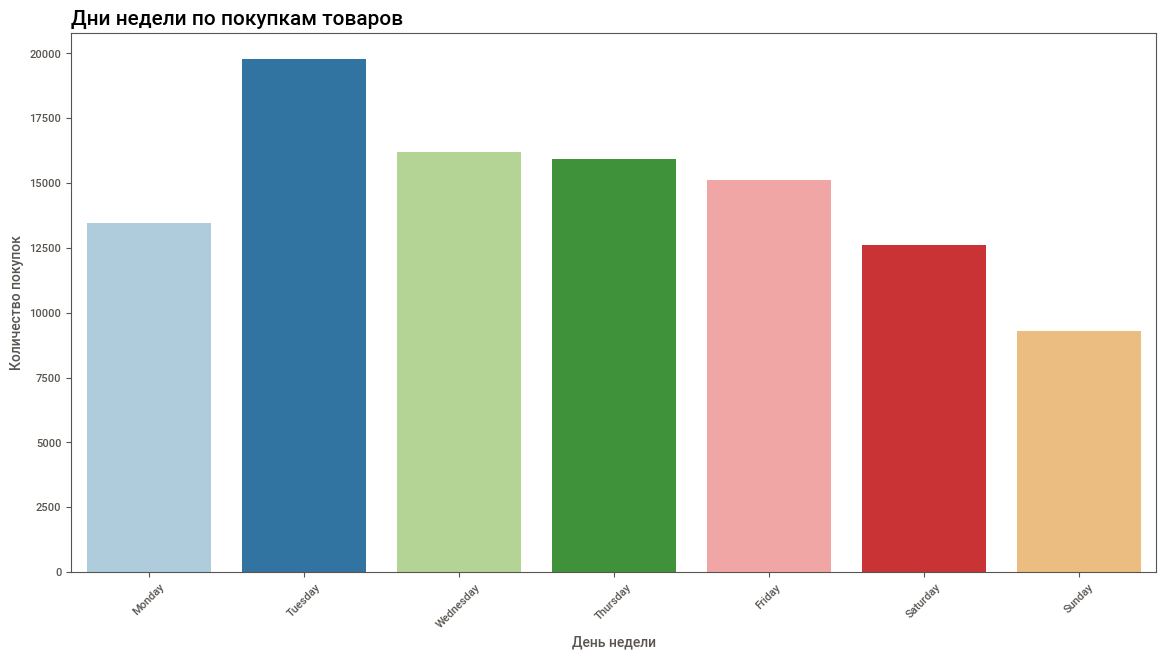

In [365]:
# Визуализируем данные с помощью seasborn barplot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=items_with_pay_by_weekday, x='day_of_week', y='count', estimator="sum", palette='Paired', errorbar=None, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('День недели')
plt.ylabel('Количество покупок')
plt.title('Дни недели по покупкам товаров', fontsize= 15 , loc='left')
plt.show()

Лучше всего товары покупались во вторник, хуже всего в воскресенье.

# Задание 4

**Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

Для задачи нам потребуется объединить объединить заказы и товары. Сделаем merge через right, чтобы подцепить продукты, которые вообще не заказывали (если такие есть).

In [366]:
# Берем общую таблицу по пользователям и заказами
customers_and_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [367]:
# Добавим колонку с кол-вом недель в месяце (покупок)
customers_and_orders['days_is_month'] = customers_and_orders.order_approved_at.dt.days_in_month / 7

In [368]:
# Добавим колонку с месяцем (покупок)
customers_and_orders['month'] = customers_and_orders['order_approved_at'].dt.month_name()

In [369]:
customers_and_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,days_is_month,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,4.000000,February
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,4.428571,March
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4.000000,February
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,4.428571,August
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,4.428571,January


In [370]:
# Создаем датафрейм с пользователями, которые совершали покупки, и данными для подсчета среднего по неделям
mean_purchase_frequency_by_week = customers_and_orders \
                .query("order_approved_at.isna() != True and order_status not in ('canceled', 'unavailable')") \
                .groupby(['customer_unique_id', 'month', 'days_is_month']) \
                .agg({'order_id': 'nunique'}) \
                .rename(columns={'order_id': 'buy_count'}) \
                .groupby(['customer_unique_id', 'month', 'days_is_month']) \
                .agg({'buy_count': 'sum'}) \
                .reset_index()

In [371]:
# Создаем колонку со средним покупок в неделю (по месяцам)
mean_purchase_frequency_by_week['mean_by_week'] = round(mean_purchase_frequency_by_week.buy_count / mean_purchase_frequency_by_week.days_is_month, 2)

In [372]:
mean_purchase_frequency_by_week.mean_by_week.value_counts()

0.23    87540
0.25     7951
0.45      749
0.47      342
0.50      163
0.68       29
0.70       14
0.75        6
0.90        4
1.00        3
0.93        2
1.35        1
Name: mean_by_week, dtype: int64

Только 6 пользователей в среднем совершают 1 и более покупок в неделю.

# Задание 5

**Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

Мы будем отслеживать возвращаемость пользователей по дате первой покупки.

Будем использовать следующие данные:
+ Дата покупки
+ Дата первой покупки
+ Уникальный номер пользователя

Для решения будем использовать функцию, которая возвращает:
1. Таблицу с заданным диапазоном дат и актуальным количеством уникальных пользоватетей в определенный период.
2. Визуализацию ретеншен в процентах в определенный период.
3. Retention rate heatmap, которая сохраняется в файл "Retention_Rate_month.png"

In [373]:
#фукнция ретеншен по месячным когортам и месячным интервалам
def retention_rate_month(df, start, end):
    
#     Приводим даты к необходимым форматам
    df['first_purchase_month'] = df['first_purchase'].dt.to_period('M')
    df['seniority_month'] = ((df['order_approved_at'] - df['first_purchase'])/np.timedelta64(1, 'M')) + 1
    df['seniority_month'] = df['seniority_month'].astype(int)
    
#     Создаем когортную таблицу
    count_month = df.groupby(['seniority_month', 'first_purchase_month'], as_index=False) \
    .agg({'customer_unique_id':'nunique'}) \
    .pivot(index='first_purchase_month', columns='seniority_month', values='customer_unique_id')[start:end]
    
#     Вычисляем retention, divide используется для деления каждого элемента колонки на соответсвующий элемент первой колонки 
    base_month = count_month[1]    
    retention_month =  count_month.divide(base_month, axis=0).mul(100).round(3)
    
#     Отрисовываем хитпам для retention
    plt.figure(figsize=(18,14))
    plt.title('Retention Table For Month')
    ax = sns.heatmap(data=retention_month.iloc[:,1:31], annot=True, vmin=0.0, vmax=1,cmap='Reds')
    ax.set_yticklabels(retention_month.index)
    fig=ax.get_figure()
    fig.savefig("Retention_Rate_month.png")
    
    return count_month.iloc[:,0:31]

In [374]:
# Берем общую таблицу по пользователям и заказам
customers_and_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,days_is_month,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,4.000000,February


In [375]:
# Отбираем пользователей, которые делали покупки, и заносим их в новый датафрейм
users_purchases = customers_and_orders.query("order_approved_at.isna() != True and order_status not in ('canceled', 'unavailable')")\
                .groupby(['customer_unique_id', 'order_approved_at']) \
                .agg({'order_id': 'nunique'}) \
                .rename(columns={'order_id': 'buy_count'}) \
                .reset_index()

In [376]:
users_purchases

,customer_unique_id,order_approved_at,buy_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,1
...,...,...,...
98099,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,1
98100,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,1
98101,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,1
98102,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:58:47,1


In [377]:
# Находим даты первых покупок
first_purchase = users_purchases.groupby(['customer_unique_id']) \
                        .agg({'order_approved_at': 'min'}) \
                        .rename(columns={'order_approved_at': 'first_purchase'}) \
                        .reset_index()

In [378]:
# Соединяем первую дату покупки со всеми покупками
full_left_users_purchases = pd.merge(users_purchases, first_purchase, how='left', on='customer_unique_id')

In [379]:
# # переводим данные о времени события в Timestamp
full_left_users_purchases['first_purchase'] = [pd.Timestamp(x,unit='s').date() for x in full_left_users_purchases['first_purchase']]
full_left_users_purchases['order_approved_at'] = [pd.Timestamp(x,unit='s').date() for x in full_left_users_purchases['order_approved_at']]

In [380]:
# переводим данные о времени события в datetime64[ns]
full_left_users_purchases['first_purchase'] = pd.to_datetime(full_left_users_purchases['first_purchase'])
full_left_users_purchases['order_approved_at'] = pd.to_datetime(full_left_users_purchases['order_approved_at'])

In [381]:
full_left_users_purchases.head()

,customer_unique_id,order_approved_at,buy_count,first_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,1,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,1,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10,1,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,1,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,1,2017-11-14


<Axes: xlabel='order_approved_at'>

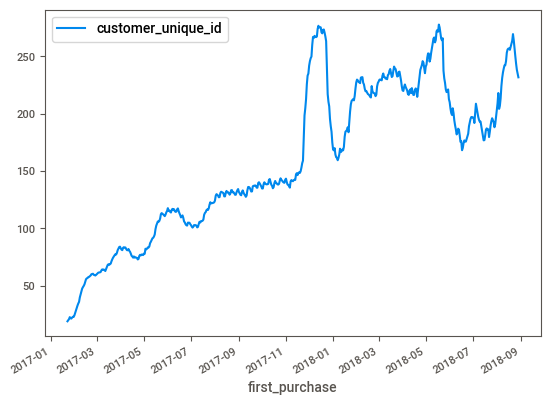

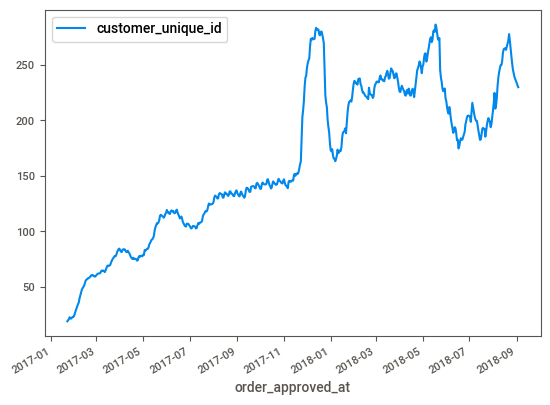

In [382]:
# посмотрим на график первых покупок и всех покупок, для сглаживания используем скользящее среднее
full_left_users_purchases.groupby('first_purchase').agg({'customer_unique_id':'nunique'}).rolling(30).mean().plot()
full_left_users_purchases.groupby('order_approved_at').agg({'customer_unique_id':'nunique'}).rolling(30).mean().plot()

График первой покупки и график всех покупок практически индентичны из-за того, что у нас большой процент (97%) пользователей, которые совершили только одну покупку

In [384]:
# Смотрим первую покупку, чтобы определить начало периода 
full_left_users_purchases.order_approved_at.min()

Timestamp('2016-09-15 00:00:00')

In [386]:
# Смотрим последнюю покупку, чтобы определить конец периода
full_left_users_purchases.order_approved_at.max()

Timestamp('2018-09-03 00:00:00')

seniority_month,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
first_purchase_month,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,291.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,2.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,716.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,1.0,...,5.0,3.0,1.0,NaN,3.0,3.0,NaN,NaN,1.0,NaN
2017-02,1674.0,3.0,3.0,6.0,4.0,3.0,4.0,2.0,1.0,4.0,...,6.0,2.0,3.0,2.0,NaN,3.0,3.0,NaN,NaN,NaN
2017-03,2580.0,7.0,14.0,9.0,3.0,3.0,8.0,6.0,6.0,9.0,...,3.0,4.0,5.0,7.0,1.0,4.0,1.0,NaN,NaN,NaN
2017-04,2301.0,8.0,6.0,NaN,8.0,8.0,6.0,9.0,6.0,4.0,...,4.0,NaN,2.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN
2017-05,3543.0,16.0,14.0,13.0,13.0,12.0,13.0,4.0,10.0,11.0,...,7.0,8.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3110.0,14.0,13.0,10.0,5.0,15.0,9.0,6.0,3.0,12.0,...,6.0,4.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


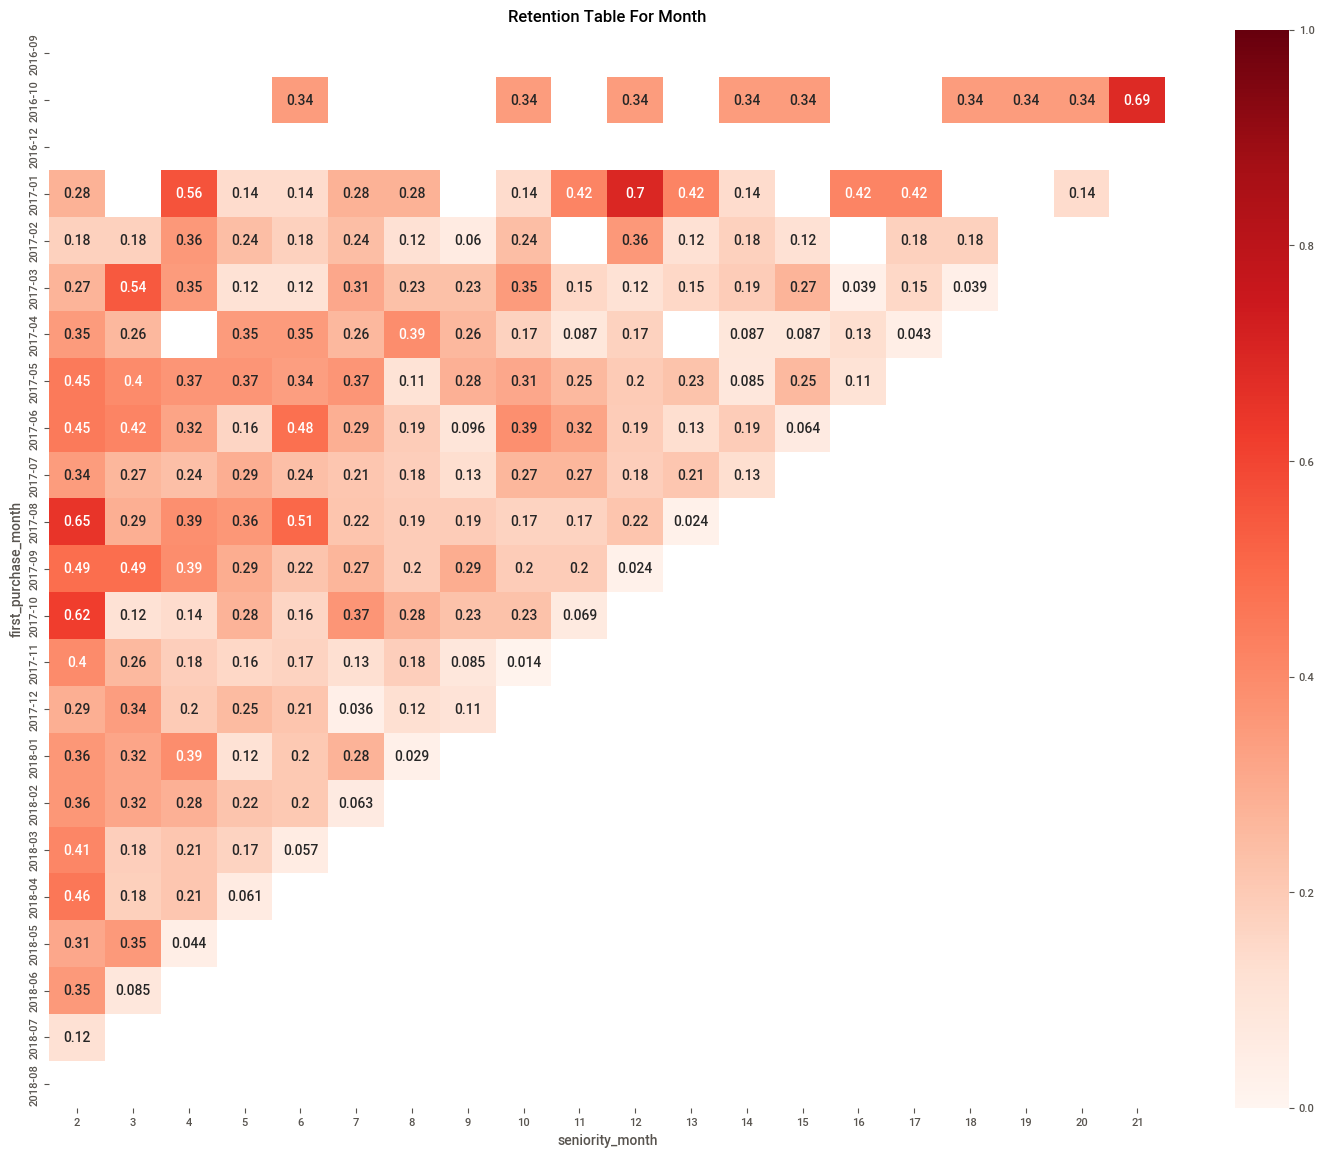

In [387]:
# Посмотрим ретеншен по месяцам с начала 2016 года
retention_rate_month(full_left_users_purchases, '2016-01-01', '2018-09-03' )

Для начала нужно определить, откуда мы будем считать 3-й месяц. Можно начать счет не включая месяц первой покупки, а можно его включить. Мы будем считать с учетом месяца первой покупки. Необходимые нам данные находятся под 3 индексом - когорта с самым высоким retention на 3й месяц была в марте 2017 года и составила около 0.54%.

Первую колонку для хитмапа убрал, ломалось значение, что визуально выглядит плохо. 

На основе полученных данных можно сделать вывод, что retention компании по месяцам крайне низкий. После первой покупки ни в один последующих месяцев retention не составил более 1%. Максимальное значение отмечается на 12-ый месяц с январь 2017 - 0.7%. Ожидаемый результат, так как у компании большой процент пользователей, которые совершили только одну покупку (она была первой и последней) - 97%. С увеличением интервала процент пользователей, которые совершали повторные покупки закономерно уменьшается у большей части месяцев, исключениями могут послужить ранние периоды в виду того, что там покупателей было меньше, отсюда более высокие проценты retention.

# Задание 6

**Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.**

RFM-анализ делит пользователей на сегменты в зависимости от давности (Recency), частоты (Frequency) и общей суммы платежей (Monetary).

- Recency — разница между текущей датой и датой последнего платежа
- Frequency — количество транзакций
- Monetary — сумма покупок

Эти три показателя нужно рассчитать отдельно для каждого покупателя. После чего поставить оценки от 1-3 или 1-5. Чем шире диапазон, тем более узкие сегменты у нас получатся.

Для решения задачи нам снова понадобится наш срощенный датасет с пользователи и заказами, дополнительно замерджим к нему датасет с товарами и их ценами. Опираться будем на дату факта оплаты.

In [388]:
# Берем общую таблицу по пользователям и заказам
customers_and_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,days_is_month,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,4.000000,February


In [389]:
# Создаем датафрейм, где объединены пользователи, заказы и товары
orders_items_customer = customers_and_orders.merge(order_items, how='left', on='order_id')

In [390]:
orders_items_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,days_is_month,month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,October,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.428571,July,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4.428571,August,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,4.285714,November,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,4.000000,February,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [391]:
# Отбираем пользователей, которые делали покупки и заносим их в новый датафрейм для RFM-анализа
rfm_df = orders_items_customer.query("order_approved_at.isna() != True and order_status not in ('canceled', 'unavailable')")\
                .groupby(['customer_unique_id', 'order_approved_at']) \
                .agg({'order_id': 'nunique', 'price': 'sum'}) \
                .reset_index()

In [392]:
# Так как датасет не самый свежий, вместо текущей даты будем использовать max+1
last_date = rfm_df['order_approved_at'].max() + datetime.timedelta(days=1)

In [393]:
last_date

Timestamp('2018-09-04 17:40:06')

In [394]:
# Создаем RFM-таблицу
rfm_table = rfm_df.groupby('customer_unique_id', as_index=False) \
                .agg({'order_approved_at': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: len(x), 
                                                 'price': lambda x: x.sum()})

In [395]:
# Переименовываем столбцы в таблице для удобства
rfm_table.rename(columns={'order_approved_at': 'recency', 
                          'order_id': 'frequency', 
                          'price': 'monetary_value'}, inplace=True)

Один из самых популярных и гибких способов сегментации - использовать квантили. Но у нас учебный проект, данные не будут обновляться постоянно, поэтому считаю, что в данном случае **можно создать собственную градацию**. RFM анализ получится менее подробный, однако комбинаций будет меньше и работать с данными будет удобнее.

При этом мы все таки посмотрим на квантили, чтобы наша градация была статистически обусловлена. В каждом квинтиле у нас будет находится 20% пользователей (при сегментации RFM часто используют именно такое разделение, возьмем как некий стандарт). 

In [396]:
# Отбираем квантили для каждого параметра
quintiles = rfm_table[['recency', 'frequency', 'monetary_value']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary_value': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Таким образом, будем использовать следующую градацию

**Давность покупки (Recency)**

- «Хороший» показатель (Группа 1) — до 180 дней;
- «Средний» показатель (Группа 2) — от 181 до 360 дней;
- «Плохой» показатель (Группа 3) — от 361 дня.

**Частота покупки (Frequency)**

- «Хороший» показатель (Группа 1) — от 5 покупок;
- «Средний» показатель (Группа 2) — от 2 до 4 покупок;
- «Плохой» показатель (Группа 3) — 1 покупка.

**Вложения (Monetary)**

- «Хороший» показатель (Группа 1) — от 181 рублей;
- «Средний» показатель (Группа 2) — от 41 до 180 рублей;
- «Плохой» показатель (Группа 3) — до 40 рублей.

In [397]:
# Заводим переменную для сегментации на основе RFM таблицы
segmented_rfm = rfm_table

Будем использовать функции для присвоения рангов от 1 до 3. Чем меньше значение R, тем лучше, а для F и M лучше более высокие показатели. Нам понадобятся 2 отдельные функции.

In [398]:
# Создаем функции для присвоения рангов
def r_score(x):
    if x <= 180:
        return 1
    elif x <= 360:
        return 2
    else:
        return 3

def f_score(x):
    if x <= 1:
        return 3
    elif x <= 4:
        return 2
    else:
        return 1 
    
def m_score(x):
    if x <= 40:
        return 3
    elif x <= 180:
        return 2
    else:
        return 1 

In [399]:
# Делаем сегментацию
segmented_rfm['R'] = segmented_rfm['recency'].apply(lambda x: r_score(x))
segmented_rfm['F'] = segmented_rfm['frequency'].apply(lambda x: f_score(x))
segmented_rfm['M'] = segmented_rfm['monetary_value'].apply(lambda x: m_score(x))

In [400]:
# Объединям оценки R, F и M в один балл RFM Score
segmented_rfm['RFM Score'] = segmented_rfm['R'].map(str) + segmented_rfm['F'].map(str) + segmented_rfm['M'].map(str)

In [401]:
segmented_rfm.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,1,3,2,132
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,3,3,133
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,3,2,332
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,3,3,233
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,3,2,232


R, F и M имеют оценки от 1 до 3 (где 1 - группа 1, 2 - группа 2, 3 - группа 3), то есть всего 3x3x3 = 27 комбинаций значений RFM. Терпимое значение, можно не сокращать (в будущем отберем самые важные).

Наши комбинации:

- 111 - недавние, частые, высокий чек
- 121 - недавние, редкие, высокий чек
- 131 - недавние, разовые, высокий чек
- 112 - недавние, частые, средний чек
- 122 - недавние, редкие, средний чек
- 132 - недавние, разовые, средний чек
- 113 - недавние, частые, низкий чек
- 123 - недавние, редкие, низкий чек
- 133 - недавние, разовые, низкий чек
- 211 - спящие, частые, высокий чек
- 211 - спящие, редкие, высокий чек
- 211 - спящие, разовые, высокий чек
- 212 - спящие, частые, средний чек
- 222 - спящие, редкие, средний чек
- 232 - спящие, разовые, средний чек
- 213 - спящие, частые, низкий чек
- 223 - спящие, редкие, низкий чек
- 233 - спящие, разовые, низкий чек
- 311 - уходящие, частые, высокий чек
- 321 - уходящие, редкие, высокий чек
- 331 - уходящие, разовые, высокий чек
- 312 - уходящие, частые, средний чек
- 322 - уходящие, редкие, средний чек
- 332 - уходящие, разовые, средний чек
- 313 - уходящие, частые, низкий чек
- 323 - уходящие, редкие, низкий чек
- 333 - уходящие, разовые, низкий чек

In [402]:
# из 27 комбинаций отберем наиболее важные для нас, которым присвоим названия и предложим стратегию взаимодействия
segt_map = {
    r'111': 'leaders',
    r'[1-3]1[1-3]': 'regular customers',
    r'[1-3][1-3]1': 'interesting customers',
    r'13[1-3]': 'new customers',
    r'33[1-3]': 'sleep customers',
    r'333': 'loose customers',
    r'2[1-3][1-3]': 'stable customers',
    r'[1-3]2[1-3]': 'stable customers',
    r'[1-3][1-3]2': 'stable customers',
}

segmented_rfm['Segment'] = segmented_rfm['R'].map(str) + segmented_rfm['F'].map(str) + segmented_rfm['M'].map(str)
segmented_rfm['Segment'] = segmented_rfm['Segment'].replace(segt_map, regex=True)


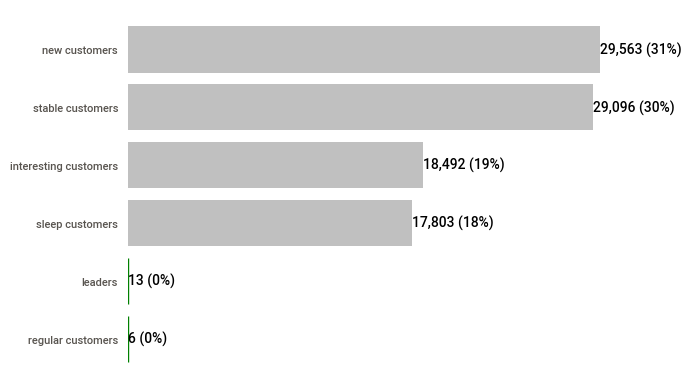

In [403]:
# Визуализируем наши резульаты
segments_counts = segmented_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['leaders', 'regular customers']:
            bar.set_color('green')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Наши основные сегменты  и рекомендации по взаимодействию с ними:

- **«leaders»** («111») — самые активные клиенты. С такими необходимо работать персонально: предлагать что-то ценное, например, золотую карту или приглашение на отраслевое мероприятие.
- **«regular customers»** (х1х) — покупают немного, но постоянно. Можно предложить сопутствующие товары, бонусную карту или участие в программе лояльности. Стимулировать данных потребителей тратить больше.
- **«interesting customers»** (хх1) — покупают редко, но зато на большие суммы. Предлагать таким клиентам нечто ценное или особенное. Важен индивидуальный подход, чтобы подтолкнуть крупных потребителей на более частые покупки.
- **«new customers»** (13х) — новые клиенты, которые в будущем могут стать лояльными. Необходимо наладить как можно больше коммуникаций: поздравить с покупкой, пригласить на сайт или в социальные сети почитать интересные и полезные статьи в блоге и т.п. Необходимо сделать из них лояльных потребителей, которые всегда будут обращаться в компанию.
- **«sleep customers»** (33х) — старые клиенты, активность которых снизилась. Выяснить, почему они перестали совершать покупки? Спровоцировать на новую сделку: индивидуальные условия, скидки, акции и т.п. Восстановить отношения и продолжать плодотворное сотрудничество.
- **«loose customers»** (333) — потерянные клиенты, которые давно не проявляли активность. Необходимо наладить контакт, предложить скидки или специальные предложения. Но если нет отклика, то стоит отказаться от дальнейшей работы и  сосредоточиться на более ценных сегментах.
- **«stable customers»** - стабильные клиенты. Сюда относятся все комбинации с двойками. Такие клиенты хорошо и стабильно покупают. Как показывает практика, на них хорошо действуют стандартные рекламные кампании, разрабатывать какие-то индивидуальные варианты не стоит.


К сожалению, у нашей компании критически низкие значения лидеров и постоянных клиентов - менее 1%, однако это закономерный результат на фоне 97% клиентов с одной покупкой. Значительную долю занимают новые клиенты - 31% (их у нас больше всего). Стабильных клиентов также достаточно много - 30%, обычно они не требуют каких либо индвидуальных подходов и для взаимодействия с ними достаточно стандартной рекламной компании. 19% пользователей покупают редко, на крупную сумму, а оставшиеся 18% - это старые кленты, активность которых снизилась до минимума. Стоит отметить, что полностью потеренные клиенты у нас отсутсвуют.